# Análise de Recortes Específicos

Por meio da análise dos dados do experimento no _software_ OpenBCI GUI, foram identificados trechos que apresentam picos de potência em bandas de frequência específicas. A seguir, os principais momentos são evidenciados.

In [229]:
import mne
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from matplotlib import rcParams

### Funções auxiliares para recorte de tempo

Na célula seguite são definidas algumas funções para automatizar o cálculo e a extração dos trechos de interesse.

In [230]:
# Transform a string that represents a time value ("min:sec") into number and converts it to seconds
def convert_min_to_sec(time):
    minutes, seconds = map(int, time.split(":"))
    return minutes * 60 + seconds

# Transfor a string thats represents a range time "0:21 - 0:40" into index that will be used to cut data
def convert_time_range_to_index(timerange):
    start, end = map(str, timerange.split(" - "))
    new_start = convert_min_to_sec(start)
    new_end = convert_min_to_sec(end)
    
    index = []
    index.append(new_start * 250)
    index.append(new_end * 250)

    return index

### O sistema de posicionamento 10-20

Os identificadores dos canais (eletrodos) fazem parte do sistema de posicionamento internacional 10-20. O nome "10-20" refere-se aos intervalos percentuais entre os eletrodos: a distância entre dois eletrodos adjacentes é de 10% ou 20% do comprimento de uma linha no crânio.

O sistema define as localizações dos eletrodos com base em marcos anatômicos, como a glabela (parte frontal proeminente) e o inion (protuberância occipital). Além disso, sistema original envolve 21 eletrodos, mas versões modificadas podem utilizar mais ou menos, dependendo do objetivo do estudo.

As posições dos eletrodos são identificadas por letras e números. As letras indicam a região do cérebro: frontal (F), central (C), parietal (P), occipital (O), temporal (T) e (Z) refere-se à linha média do crânio (como em Fz, Cz, Pz). Em contrapartida, os números representam a lateralidade: ímpares indicam o lado esquerdo, enquanto que os pares designam o lado direito e zero (ou z) indica a linha média.

<img src="../../imgs/the-10-20-system.webp" alt="sistema1020" width="500" />


### Definição do objeto MNE `info`

O trecho de código a seguir define o objeto MNE `info` que será usado para o carregamento dos dados (em conjunto com o MNE `RawArray`).

Para tal, é necessário fornecer os dados do eletroencefalograma utilizado no experimento, que incluem:

- Informar o tipo e a quantidade de canais (8 canais de EEG);
- Especificar a taxa de amostragem do aparelho (250 Hz);
- Inserir os identificadores dos canais do EEG (F3, Fz, F4, C3, Cz, C4, P3, P4);
- Configurar qual é a padronização de posicionamento dos eletrodos utilizada (sistema 10-20).

In [231]:
n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


### Carregamento dos dados

O trecho de código a seguir carrega os dados obtidos pelo eletroencefalograma.

In [232]:
# Carregando os dados
# gt = '../dataset-s7/GT/OpenBCI-RAW-2023-09-19_14-58-42_GT.txt'
# gt_ob = np.loadtxt(gt, delimiter=',', skiprows=5, usecols=range(1, 9))

ia = '../dataset-s7/IA/OpenBCI-RAW-2023-09-28_16-51-25_IA.txt'
ia_ob = np.loadtxt(ia, delimiter=',', skiprows=5, usecols=range(1, 9))

# tf = '../dataset-s7/TF/OpenBCI-RAW-2023-11-07_13-17-01_TF.txt'
# tf_ob = np.loadtxt(tf, delimiter=',', skiprows=5, usecols=range(1, 9))

### Definição dos momentos de interesse

O trecho de código a seguir define os recortes de tempo de interesse (_timeranges_) para cada uma das aulas/sessões.

In [233]:
# Aula GT
gt_timeranges = [
    "2:14 - 2:32", # mais gama
    "3:47 - 4:01", # ok
    "5:17 - 5:30", # parecia algo (mas só tetha)
]

# Aula IA
ia_timeranges = [
    "2:07 - 2:18", # muito gama (junto ao beta) remover?
    "3:52 - 4:11", # beta [parecia] interessante (na vdd nem tanto)
    "5:49 - 6:06", # betinha (menos ainda) salada
    "18:48 - 19:11" # betinha
]

# Teste Final
tf_timeranges = [
    "4:40 - 4:47",
    "5:40 - 5:45",
    "6:40 - 7:00",
    "7:12 - 7:29",
    "8:05 - 8:29",
    "10:22 - 10:42"
]

### Recorte dos dados

A célula a seguir efetua o recorte nos dados de acordo os momentos de interesse e transforma para o objeto MNE `RawArray`.

In [234]:
# gt_index = []
# gt_index = convert_time_range_to_index(gt_timeranges[2])

ia_index = []
ia_index = convert_time_range_to_index(ia_timeranges[1])

# tf_index = []
# tf_index = convert_time_range_to_index(tf_timeranges[5])

# Obtendo trecho de interesse
# data_cut_gt = gt_ob[gt_index[0]:gt_index[1], :]
data_cut_ia = ia_ob[ia_index[0]:ia_index[1], :]
# data_cut_tf = tf_ob[tf_index[0]:tf_index[1], :]


X = {
    # 'gt': mne.io.RawArray(data_cut_gt.T, info),
    'ia': mne.io.RawArray(data_cut_ia.T, info),
    # 'tf': mne.io.RawArray(data_cut_tf.T, info),
}

Creating RawArray with float64 data, n_channels=8, n_times=4750
    Range : 0 ... 4749 =      0.000 ...    18.996 secs
Ready.


### Filtragem dos dados

O laço a seguir aplica dois filtros nos dados. Primeiramente, atenua-se com um filtro _notch_ a frequência de 60Hz de forma a evitar a interferência da rede elétrica e, posteriormente, obtém-se a faixa de frequência desejada de 4 a 100Hz com um filtro passa faixa.

In [235]:
for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband e

### Metodologia

Com o objetivo de evidenciar a presença da banda de frequência beta em um trecho no qual a mesma foi observada durante a análise dos dados do experimento no _software_ OpenBCI, este trabalho realiza os seguintes testes:

Aula Glucagon com metodologia de ensino tradicional: <br>
- Testes com `ref_channels='average'`:
    - [Apresentar os trechos de tempo]
- Testes com `ref_channels='[centrais e frontais]'`:
    - [Apresentar os trechos de tempo]
- Testes com `ref_channels='[frontais]'`:
    - [Apresentar os trechos de tempo]

Aula Insulina com metodologia de ensino ativa:
- Testes com `ref_channels='average'`:
    - [Apresentar os trechos de tempo]
- Testes com `ref_channels='[centrais e frontais]'`:
    - [Apresentar os trechos de tempo]
- Testes com `ref_channels='[frontais]'`:
    - [Apresentar os trechos de tempo]

#### Janela de Tempo Deslizante

O trecho de código a seguir determina a porcentagem do tempo em que cada banda de frequência é dominante ao longo de uma janela de tempo específica.

Conforme cita [Hatton SL et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10426816/), as ondas cerebrais beta (13 – 35 Hz) são mais dominantes na região fronto-central do cérebro. Dessa forma, serão escolhidos os eletrodos F3, Fz, F4, C3, Cz e C4 que correspondem à região fronto-central como canais de referência para a aplicação do CAR através do método `set_eeg_reference()`.

In [236]:
sr = 250            # Taxa de amostragem dos dados do EEG (250Hz)
jump = 4            # Tamanho da janela de análise (4 em 4 segundos)
size = sr * jump    # Número de pontos de dados em cada janela de análise

# Definindo os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz


total_pc = {}
# data_names = ('gt', 'ia', 'tf')
data_names = ('ia',)

electrodes = ["F3", "Fz", "F4"] # , "C3", "Cz", "C4"

# X contém os cinco conjuntos de dados de EEG para análise
for k, data in enumerate(X.values()):
    results = [0, 0, 0, 0] # Contagem de dominância de cada banda

    data.set_eeg_reference(ref_channels='average', projection=False)
    
    # Percorre os dados em incrementos de sr (1 segundo) extraindo janelas de tamanho size (4s)
    for i in range(0, int(data.times[-1] - jump), 1):
        tmin = i
        tmax = i + jump

        cut = data.copy().crop(tmin=tmin, tmax=tmax).get_data()

        # Número de pontos por segmento
        n_per_seg = 128
        # Quantidade de sobreposição entre segmentos
        n_overlap = n_per_seg // 2 # 64
        
        # Calculando a densidade espectral de potência (PSD)
        freqs, psd = welch(cut, fs=sr, nperseg=n_per_seg, noverlap=n_overlap)
        
        # realizando a média dos 8 eletrodos
        X = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        # Calculando a potência em cada banda de frequência por meio da integração da PSD
        bands = [np.sum(X[theta_idxs]), np.sum(X[alpha_idxs]), np.sum(X[beta_idxs]), np.sum(X[gamma_idxs])]
        # Calculando a pontuação de cada banda para mostrar a porcentagem
        results[np.argmax(bands)] += 1

    total = sum(results)
    percentages = [round((count/total) * 100, 2) for count in results]
    print(data.__str__())
    total_pc[data_names[k]] = percentages

print(total_pc)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
<RawArray | 8 x 4750 (19.0 s), ~314 kB, data loaded>
{'ia': [20.0, 0.0, 13.33, 66.67]}


### Resultados

[Descrever resultados dos testes propostos]

[Apresentar os resultados dos testes descritos na metodologia]

Dos recortes temporais apresentados acima, apenas o melhor resultado de cada teste será exibido nesta sessão.

#### Aula Glucagon com metodologia de ensino tradicional:
- Testes com `ref_channels='average'` (escolher 1 momento e):
    - [Gráfico de barras: porcentagem do tempo proeminente]
    - [outros gráficos]
- Testes com `ref_channels='[centrais e frontais]'`:
    - [Gráfico de barras: porcentagem do tempo proeminente]
    - [outros gráficos]
- Testes com `ref_channels='[frontais]'`:
    - [Gráfico de barras: porcentagem do tempo proeminente]
    - [outros gráficos]

#### Aula Insulina com metodologia de ensino ativa:
- Testes com `ref_channels='average'`:
    - [Gráfico de barras: porcentagem do tempo proeminente]
    - [outros gráficos]
- Testes com `ref_channels='[centrais e frontais]'`:
    - [Gráfico de barras: porcentagem do tempo proeminente]
    - [outros gráficos]
- Testes com `ref_channels='[frontais]'`:
    - [Gráfico de barras: porcentagem do tempo proeminente]
    - [outros gráficos]

Dito isso, as células a seguir apresentam visualmente os resultados do processamento dos dados. São exibidos:

- Gráfico de barra com a porcentagem de tempo em que cada banda de frequência esteve proeminente. No eixo vertical tem-se a porcentagem de tempo durante a atividade, enquanto que no eixo horizontal, cada barra representa uma banda de frequência cerebral;
- Gráfico de sinais no domínio do tempo que exibe amplitude do sinal (no eixo vertical) ao longo do tempo (no eixo horizontal);
- Gráfico de densidade espectral de potência (PSD) no domínio da frequência medindo a quantidade de energia presente em cada faixa de frequência. No eixo vertical, tem-se a PSD em decibéis por hertz (dB/Hz), enquanto no eixo horizontal está a frequência em hertz (Hz).
- Espectograma mostrando como o espectro de frequências de um sinal varia ao longo do tempo. O eixo das ordenadas é composto pela frequência (Hz) e o eixo das abscissas tem-se o tempo.

In [237]:
rcParams['figure.figsize'] = [6., 4.]

def plot_bar(x):
    colors = ('orange', 'green', 'blue', 'purple')
    bars = plt.bar(('theta', 'alpha', 'beta', 'gamma'), x, color=colors)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    plt.title('Porcentagem de tempo cuja cada banda de\nfrequência teve sua potência proeminete')
    plt.xlabel('Banda de Frequência')
    plt.ylabel('Porcentagem de tempo da atividade')
    plt.show()


Insulina Ativa


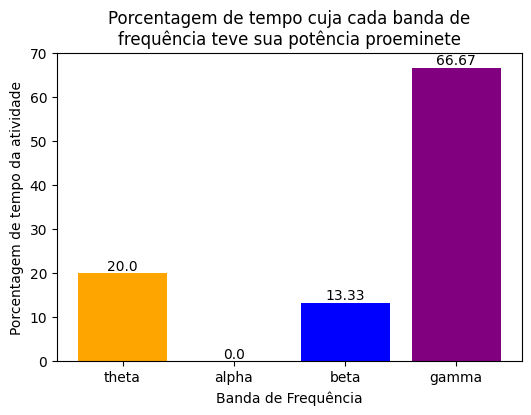

In [238]:
# print('Glucagon Tradicional')
# plot_bar(total_pc['gt'])

print('Insulina Ativa')
plot_bar(total_pc['ia'])

# print('Teste Final')
# plot_bar(total_pc['tf'])

In [239]:
def print_graphs(X):
    for i in range(X.shape[1]):
        plt.plot(X[:,i])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(X.shape[1]):
        plt.psd(X[:,i], Fs=250)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(X.shape[1]):
        plt.specgram(X[i,:], Fs=250)
    plt.title('Espectrograma')
    plt.show()

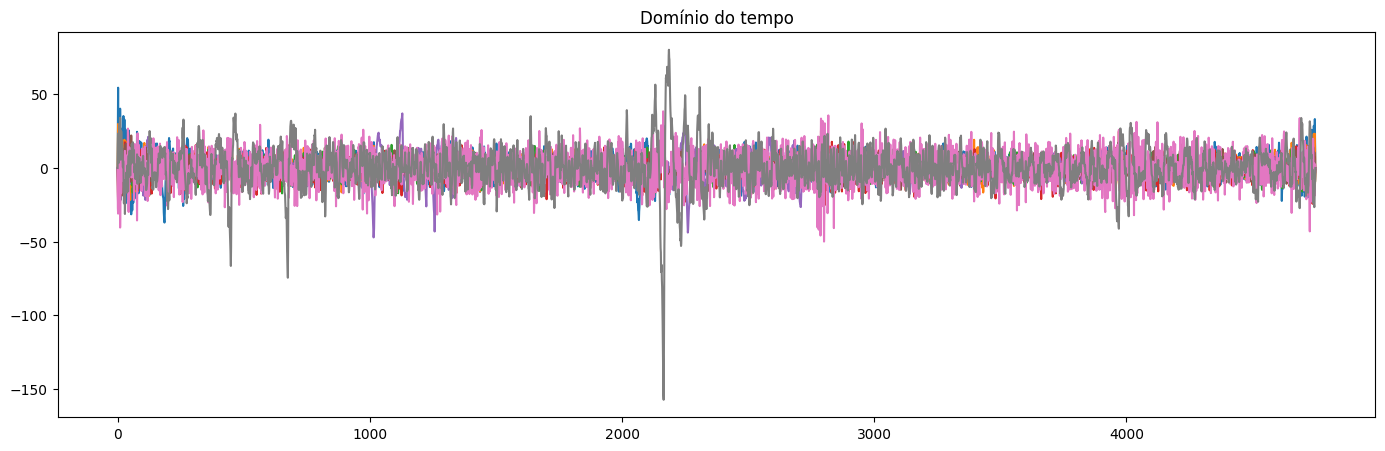

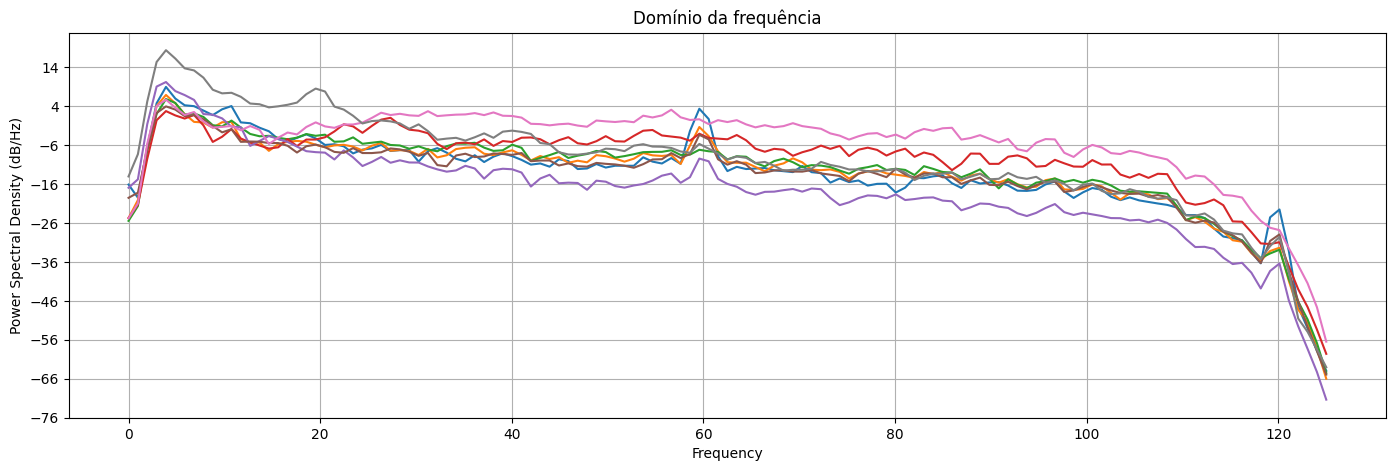

/tmp/ipykernel_4234/291471394.py:13: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=8).
  plt.specgram(X[i,:], Fs=250)


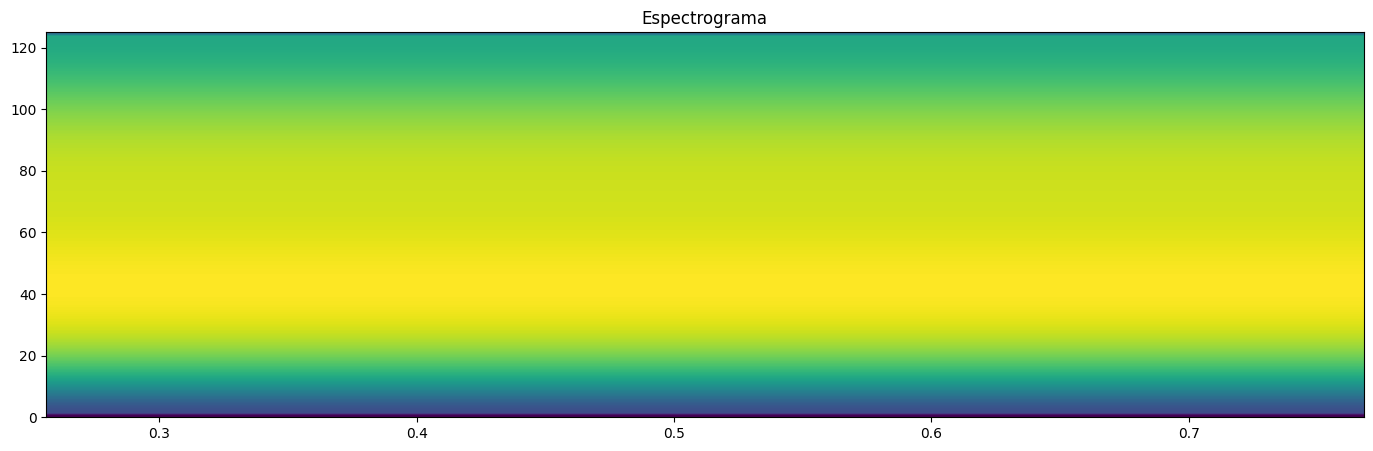

In [240]:
rcParams['figure.figsize'] = [17., 5.]

# for key in X:
#     print_graphs(X[key])

# print_graphs(data_cut_gt)
print_graphs(data_cut_ia)
# print_graphs(data_cut_tf)

### Conclusões

[A fazer]

### Referências

Hatton SL, Rathore S, Vilinsky I, Stowasser A. _**Quantitative and Qualitative Representation of Introductory and Advanced EEG Concepts: An Exploration of Different EEG Setups**_. J Undergrad Neurosci Educ. 2023 May 19;21(2):A142-A150. doi: 10.59390/GEBE4090. PMID: 37588651; PMCID: PMC10426816.

### Tarefas

- [x] 1. Testar jumps com valores diferentes
    - timerange8 "19:18 - 19:35":
        - jump = 3: `'ia': [23.08, 0.0, 0.0, 76.92]`
        - jump = 5: `'ia': [0.0, 0.0, 0.0, 100.0]`
        - jump = 7: `'ia': [0.0, 0.0, 0.0, 100.0]`

    - timerange3 "3:54 - 5:00":
        - jump = 3: `'ia': [51.61, 1.61, 3.23, 43.55]`
        - jump = 4: `'ia': [57.38, 0.0, 0.0, 42.62]`
        - jump = 5: `'ia': [63.33, 0.0, 0.0, 36.67]`
        - jump = 7: `ia': [68.97, 0.0, 0.0, 31.03]`
- alternar entre 3 e 4.

- [x] 2. Encontrar momentos do TF

- [x] 3. Pesquisar quais eletrodos podem apresentar beta maior, inseri-los numa lista e passar para `ref_channels` em `set_eeg_reference`

- [x] 4. Automatizar extração 

- [x] 5. housekeeping: excluir arquivos antigos inúteis

<br>

- 6. Tarefa 2
    - [x] 6.0 Reanalisar os 3 arquivos a fim de encontrar beta (no máximo 3 trechos por arquivo).
    - 6.1 Testes com `ref_channels='average'`: citar na metodologia e resultados
    - 6.2 Testes com `ref_channels=[centrais e frontais]`: citar na metodologia e resultados
    - 6.3 Testes com `ref_channels=[frontais]`: citar na metodologia e resultados
    - 6.4 Elaborar Conclusão

- 7. Metodologia
    - 7.1 Descrever o objetivo da janela deslizante
    - 7.2 Explicar PSD e Welch

- 8. Introdução
    - 8.1 O que sabe-se sobre ondas cerebrais
    - 8.2 Contexto/justificativa MNE
    - Perguntar: inserir 10-20 e PSD aqui?
